In [157]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
sns.set_context('paper', font_scale=1.5)

heatmap_cmap = 'GnBu'

import scipy
from scipy.stats import ttest_rel, beta, ttest_ind
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
import numpy as np
import os
import yaml
import shutil
from collections import OrderedDict

from utils import quick_load_experiments_tsv, get_significance_by_column, add_probing_location_better_column
from common import lang2code, code2lang, lang2family, family2langs, lang2large_family

figure_dir = "fig/typology"
os.makedirs("fig", exist_ok=True)
os.makedirs(figure_dir, exist_ok=True)

np.random.seed(2)

%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [158]:
exps = pd.read_table("../dataframes/exps.tsv", sep="\t", quoting=3)
exps['tag'] = exps['task'].apply(lambda t: t.split("_")[0])
exps['pos'] = exps['task'].apply(lambda t: t.split("_")[1])
exps['full_task'] = exps['language'] + ' ' + exps['task']
exps['family'] = exps['language'].apply(lambda l: lang2family[l])

exps = add_probing_location_better_column(exps)

In [159]:
exps

,model,language,task,perturbation,probing_location,dev_acc,test_acc,tag,pos,full_task,family,probing_location_better
0,mBERT,Afrikaans,number_noun,B$_2$,first,0.848571,0.819286,number,noun,Afrikaans number_noun,Germanic,False
1,mBERT,Afrikaans,number_noun,B$_2$,last,0.983571,0.952143,number,noun,Afrikaans number_noun,Germanic,True
2,mBERT,Afrikaans,number_noun,L$_2$,first,0.892143,0.860000,number,noun,Afrikaans number_noun,Germanic,False
3,mBERT,Afrikaans,number_noun,L$_2$,last,0.975714,0.949286,number,noun,Afrikaans number_noun,Germanic,True
4,mBERT,Afrikaans,number_noun,R$_2$,first,0.887857,0.829286,number,noun,Afrikaans number_noun,Germanic,False
...,...,...,...,...,...,...,...,...,...,...,...,...
3823,mBERT,Urdu,number_noun,permute,first,0.863571,0.855714,number,noun,Urdu number_noun,Indic,False
3824,mBERT,Urdu,number_noun,permute,last,0.937143,0.917857,number,noun,Urdu number_noun,Indic,True
3825,mBERT,Urdu,number_noun,prev1,last,0.925000,0.885714,number,noun,Urdu number_noun,Indic,True
3826,mBERT,Urdu,number_noun,NaN,first,0.917857,0.838571,number,noun,Urdu number_noun,Indic,False


In [160]:
data_perturbations = ['L$_2$', 'R$_2$', 'B$_2$', 'permute']
model_perturbations = [

    'prev1',
    'next1'
]
baseline_models = []

In [161]:
bert_exps = exps[
    (exps.model=='mBERT') &
    (exps.probing_location_better==True)
]

bert_exps.shape

(2233, 12)

In [162]:
bert_exps.groupby(['language', 'task', 'perturbation'], dropna=False).size().value_counts()

1    2233
dtype: int64

In [163]:
unperturbed = bert_exps[bert_exps.perturbation.isnull()]
unperturbed = unperturbed.set_index(['language', 'task']).test_acc

In [164]:
perturbed = bert_exps[bert_exps.perturbation.isin(model_perturbations + data_perturbations)].pivot_table(
    index=['language', 'task'], columns='perturbation', values='test_acc'
)

In [165]:
perturbed

perturbation                            B$_2$     L$_2$     R$_2$     next1  \
language          task                                                        
Afrikaans         number_noun        0.952143  0.949286  0.943571  0.850000   
Albanian          case_noun          0.622143  0.647857  0.714286  0.598571   
                  case_propn         0.805714  0.822143  0.819286  0.755714   
                  definite_noun      0.896429  0.906429  0.914286  0.809286   
                  gender_noun        0.848571  0.865714  0.865000  0.849286   
                  gender_propn       0.815000  0.812857  0.804286  0.714286   
                  number_noun        0.906429  0.897857  0.912143  0.871429   
                  number_verb        0.898571  0.905000  0.908571  0.754286   
Arabic            aspect_verb        0.942857  0.940000  0.955000  0.952857   
                  case_adj           0.647477  0.639659  0.680171  0.552950   
                  case_noun          0.555792  0.580668  0.749112  0.683014   
                  definite_noun      0.746979  0.853589  0.760483  0.851457   
                  gender_adj         0.971429  0.971429  0.970714  0.910714   
                  gender_verb        0.926429  0.942857  0.897143  0.884286   
Armenian          animacy_noun       0.827143  0.811429  0.850000  0.775714   
                  definite_noun      0.989286  0.982143  0.989286  0.776429   
                  subcat_verb        0.766429  0.739286  0.781429  0.782857   
Basque            case_noun          0.930964  0.937116  0.922078  0.607656   
                  definite_noun      0.844286  0.845714  0.864286  0.744286   
                  number_noun        0.894286  0.915714  0.903571  0.879286   
Bulgarian         aspect_verb        0.833571  0.822857  0.826429  0.774286   
                  definite_adj       0.984286  0.987143  0.985000  0.830000   
                  definite_noun      0.961429  0.951429  0.953571  0.877857   
                  gender_adj         0.998579  1.000000  0.999289  0.765458   
                  gender_noun        0.893390  0.895522  0.911869  0.793888   
                  number_adj         0.977857  0.988571  0.977857  0.957143   
                  number_verb        0.970000  0.962857  0.975000  0.857143   
                  person_verb        0.959488  0.941009  0.953802  0.739161   
                  tense_verb         0.837953  0.854300  0.882018  0.699360   
                  verbform_verb      0.975000  0.979286  0.987143  0.870000   
                  voice_verb         0.985000  0.985714  0.985000  0.955000   
Catalan           gender_adj         1.000000  1.000000  0.997857  0.912143   
                  gender_noun        0.965714  0.963571  0.970000  0.941429   
                  mood_verb          0.988571  0.987143  0.992857  0.910000   
                  number_adj         0.995000  0.995000  0.996429  0.963571   
                  number_noun        0.990000  0.990000  0.990000  0.947857   
                  number_verb        1.000000  0.997857  0.997857  0.942857   
                  tense_verb         0.977857  0.977857  0.976429  0.907143   
                  verbform_verb      1.000000  0.998586  1.000000  0.884724   
Croatian          case_adj           0.733380  0.802687  0.924328  0.660537   
                  case_noun          0.766106  0.785714  0.883053  0.676471   
                  definite_adj       0.980714  0.985714  0.977143  0.915000   
                  gender_adj         0.680171  0.793177  0.672353  0.562189   
                  gender_noun        0.840085  0.855011  0.872779  0.786780   
                  number_adj         0.910714  0.941429  0.950714  0.882143   
                  number_noun        0.879286  0.919286  0.925714  0.901429   
                  number_verb        0.985714  0.982857  0.980714  0.887857   
                  tense_verb         0.989286  0.990000  0.992857  0.932857   
                  verbform_verb      0.991471  0.9

In [166]:
test_effect = 100 * (1 - perturbed / unperturbed.values[:, None])

In [167]:
test_effect.mean()

perturbation
B$_2$       3.999094
L$_2$       1.723792
R$_2$       1.156029
next1      12.313202
permute     5.482883
prev1       8.536067
dtype: float64

In [168]:
test_effect.columns

Index(['B$_2$', 'L$_2$', 'R$_2$', 'next1', 'permute', 'prev1'], dtype='object', name='perturbation')

In [169]:
#areas = pd.read_csv("../dataframes/wals/wals_areas.tsv", sep="\t")
#feat2area = dict(areas[['Name', 'Area']].drop_duplicates().values)
#feat2area['Family'] = 'Family'

terraling_languages = []
terraling = []
for fn in os.listdir('../dataframes/terraling'):
    if not fn.endswith('csv'):
        continue
    lang = fn.split(".")[0]
    terraling_languages.append(lang)
    df = pd.read_csv(f"../dataframes/terraling/{lang}.csv", encoding='latin1')
    df = df.sort_values('Name').pivot(index='Language', columns='Name', values='Value')
    terraling.append(df)

terraling = pd.concat(terraling, sort=True)
terraling.index = terraling_languages
terraling.loc['Slovak'] = np.nan
terraling.loc['Latvian'] = np.nan
terraling.loc['Urdu'] = np.nan
terraling = terraling.drop(columns=['latlong', 'ISO 639-3 Code'])
terraling['Family'] = terraling.index.map(lambda l: lang2family[l])
print(terraling.shape), terraling.isnull().stack().mean()

(39, 172)


(None, 0.3539057841383423)

In [170]:
te = test_effect[model_perturbations + data_perturbations].copy()
te['HAS_TASK'] = 1
logreg_perts = te.columns
te = te.unstack()
te = te.fillna(0)
te['HAS_TASK'] = te['HAS_TASK'].fillna(0)

In [171]:
te

perturbation            prev1                                          \
task              animacy_adj animacy_noun animacy_propn animacy_verb   
language                                                                
Afrikaans            0.000000     0.000000      0.000000     0.000000   
Albanian             0.000000     0.000000      0.000000     0.000000   
Arabic               0.000000     0.000000      0.000000     0.000000   
Armenian             0.000000     3.862661      0.000000     0.000000   
Basque               0.000000     0.000000      0.000000     0.000000   
Bulgarian            0.000000     0.000000      0.000000     0.000000   
Catalan              0.000000     0.000000      0.000000     0.000000   
Croatian             0.000000     0.000000      0.000000     0.000000   
Czech                5.701079     5.584192     -0.988593     7.169529   
Danish               0.000000     0.000000      0.000000     0.000000   
Dutch                0.000000     0.000000      0.000000     0.000000   
English              0.000000     0.000000      0.000000     0.000000   
Estonian             0.000000     0.000000      0.000000     0.000000   
Finnish              0.000000     0.000000      0.000000     0.000000   
French               0.000000     0.000000      0.000000     0.000000   
German               0.000000     0.000000      0.000000     0.000000   
Greek                0.000000     0.000000      0.000000     0.000000   
Hebrew               0.000000     0.000000      0.000000     0.000000   
Hindi                0.000000     0.000000      0.000000     0.000000   
Hungarian            0.000000     0.000000      0.000000     0.000000   
Italian              0.000000     0.000000      0.000000     0.000000   
Latin                0.000000     0.000000      0.000000     0.000000   
Latvian              0.000000     0.000000      0.000000     0.000000   
Lithuanian           0.000000     0.000000      0.000000     0.000000   
Norwegian_Bokmal     0.000000     0.000000      0.000000     0.000000   
Norwegian_Nynorsk    0.000000     0.000000      0.000000     0.000000   
Persian              0.000000     0.000000      0.000000     0.000000   
Polish               4.521868     1.388889      0.000000     0.000000   
Portuguese           0.000000     0.000000      0.000000     0.000000   
Romanian             0.000000     0.000000      0.000000     0.000000   
Russian              7.514881     3.426295      0.455581     0.000000   
Serbian              0.000000     0.000000      0.000000     0.000000   
Slovak               4.861631     2.825279      0.000000     0.000000   
Slovenian            0.000000     0.000000      0.000000     0.000000   
Spanish              0.000000     0.000000      0.000000     0.000000   
Swedish              0.000000     0.000000      0.000000     0.000000   
Turkish              0.000000     0.000000      0.000000     0.000000   
Ukrainian            0.000000     3.582555      0.000000     0.000000   
Urdu                 0.000000     0.000000      0.000000     0.000000   

perturbation                                                               \
task              aspect_adj aspect_verb   case_adj  case_noun case_propn   
language                                                                    
Afrikaans           0.000000    0.000000   0.000000   0.000000   0.000000   
Albanian            0.000000    0.000000   0.000000  18.153846   6.557377   
Arabic              0.000000    1.445967  12.686567  21.153846   0.000000   
Armenian            0.000000    0.000000   0.000000   0.000000   0.000000   
Basque              0.000000    0.000000   0.000000  18.727140   0.000000   
Bulgarian           0.000000    2.149613   0.000000   0.000000   0.000000   
Catalan             0.000000    0.000000   0.000000   0.000000   0.000000   
Croatian            0.000000    0.000000  25.570776  24.228029   0.000000   
Czech              -0.236220    0.974026  28.407351   0.000000  25.423729   
Danish   

In [172]:
lin_acc = []
K = 3

for col in terraling.columns:
    target = terraling[col].dropna()
    common = sorted(set(target.index) & set(te.index))
    label_cnt = target.value_counts()
    large_classes = label_cnt[label_cnt>=K]
    if len(large_classes) < 2:
        continue
    target = target[target.isin(large_classes.index)]
    if target.value_counts(normalize=True).max() > 0.8:
         continue
    if len(label_cnt) < 2:
        continue
    te_common = te.loc[target.index]
    for pert in logreg_perts:
        X = te_common[pert]
        score = cross_val_score(
            LogisticRegression(solver='liblinear', multi_class='auto', max_iter=200),
            X, target, cv=3, scoring='f1_macro')
        notnull = len(target)
        lin_acc.append({
            'perturbation': pert, 'feature': col, 'score': score.mean(),
            'notnull': notnull, 'labels': dict(target.value_counts())})
    X = te_common
    score = cross_val_score(LogisticRegression(
        solver='liblinear', multi_class='auto', max_iter=200), X, target, cv=3, scoring='f1_macro')
    notnull = len(target)
    lin_acc.append({'perturbation': 'ALL', 'feature': col, 'score': score.mean(),
                    'notnull': notnull, 'labels': dict(target.value_counts())})
lin_acc = pd.DataFrame(lin_acc)

/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/

/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/

/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/

/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/

/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/

/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/

/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/

/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/

/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/

/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/

/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/

/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/

/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/

In [173]:
pd.set_option('display.max_rows', 500)
l = lin_acc.sort_values('score', ascending=False).copy()

In [176]:
l

,perturbation,feature,score,notnull,labels
472,prev1,S01A1_ Existential constructions: locative PP ...,1.000000,13,"{'No': 9, 'Yes': 4}"
277,permute,O 07 1_Unique Ref_Can be bare,0.896296,21,"{'No': 14, 'Yes': 7}"
167,ALL,O 02 4.2_DefMass_N-Art,0.888889,22,"{'No': 14, 'Yes': 8}"
514,L_2,S03_1 Indef Sg count Ns (Subj) can be bare,0.866667,14,"{'No': 9, 'Yes': 5}"
382,HAS_TASK,Q09_Affirmative answer by V,0.863889,29,"{'Yes': 16, 'No': 13}"
...,...,...,...,...,...
555,R_2,V_Aux 01_Aux.Selection,0.261905,30,"{'No': 20, 'Yes': 10}"
289,next1,O 08 2_PN_Can have an article,0.252646,20,"{'No': 10, 'Yes': 10}"
298,L_2,O 08 5.1_Art-PN,0.243386,21,"{'No': 11, 'Yes': 10}"
323,R_2,O 09 3_PN+A_Must have an article,0.238095,20,"{'No': 12, 'Yes': 8}"


In [175]:
l.perturbation = l.perturbation.str.replace('$', '')

/tmp/ipykernel_5337/1303587679.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  l.perturbation = l.perturbation.str.replace('$', '')


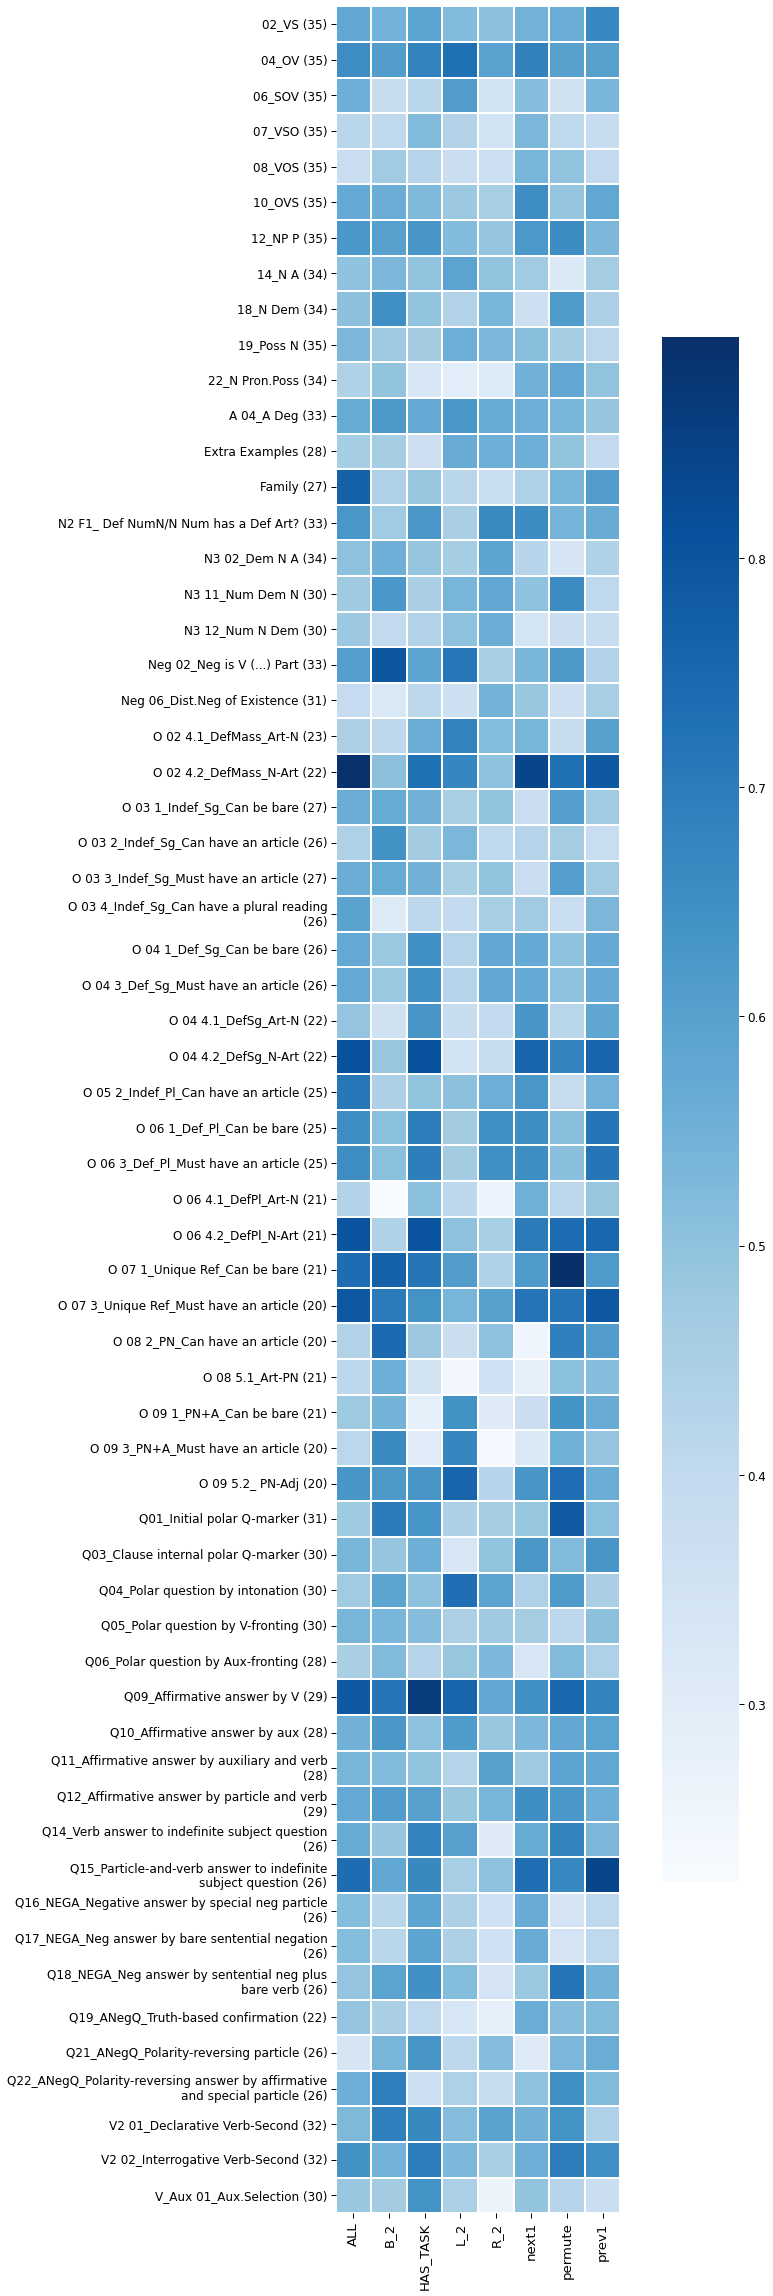

In [177]:
features = set(l[l['notnull']>=20].groupby('feature').score.mean().sort_values(ascending=False).index)

def wrap_text(text, maxline=40):
    lines = []
    this_line = []
    for word in text.split(" "):
        this_line.append(word)
        if sum(len(w) + 1 for w in this_line) - 1 >= maxline:
            lines.append(" ".join(this_line))
            this_line = []
    if this_line:
        lines.append(" ".join(this_line))
    return "\n".join(lines)
        
def plot_wals_pert_heatmap(data, save_fn=None, title=None):
    notnull = data[['feature', 'notnull']].drop_duplicates().set_index('feature')['notnull']
    table = data.pivot(index='feature', columns='perturbation', values='score')
    ysize = max(len(table), 6)
    max_text_len = data['feature'].str.len().max()
    scale = 'small' if max_text_len >= 85 else 'large'
    with matplotlib.rc_context(rc={'ytick.labelsize': 'large'}):
        fig, ax = plt.subplots(1, figsize=(15, 32))
        sns.heatmap(table, cmap='Blues', ax=ax, linewidth=.1, square=True, cbar_kws={'shrink': 0.7})
        ticks = []
        for tick in ax.get_yticklabels():
            t = tick.get_text()
            t = "{} ({})".format(t, notnull.loc[t])
            tick.set_text(wrap_text(t))
            ticks.append(tick)
        ax.set_yticklabels(ticks)
        ax.set_ylabel("")
        ax.set_xlabel("")
        plt.subplots_adjust(left=0.5)
        plt.tight_layout()
        if title:
            ax.set_title(title)
        if save_fn:
            fig.savefig(save_fn)
plot_wals_pert_heatmap(l[l.feature.isin(features)], save_fn=f"{figure_dir}/heatmap_terraling_logreg.png")

In [182]:
lin_acc = []
K = 3

linreg_scores = []

for pert in model_perturbations + data_perturbations:
    target = test_effect[pert].mean(level=0)
    target = target.drop(['Slovak','Latvian','Urdu'])
    features = pd.get_dummies(terraling.drop(['Slovak','Latvian','Urdu']).fillna('Nan'))
    score = cross_val_score(
        SVR(),
        features, target, cv=3, scoring='neg_root_mean_squared_error')
    linreg_scores.append({'perturbation': pert, 'score': score.mean()})
linreg_scores = pd.DataFrame(linreg_scores)

/tmp/ipykernel_5337/1902077359.py:7: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  target = test_effect[pert].mean(level=0)
/tmp/ipykernel_5337/1902077359.py:7: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  target = test_effect[pert].mean(level=0)
/tmp/ipykernel_5337/1902077359.py:7: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  target = test_effect[pert].mean(level=0)
/tmp/ipykernel_5337/1902077359.py:7: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecat

In [183]:
linreg_scores

,perturbation,score
0,prev1,-3.179694
1,next1,-4.354972
2,L$_2$,-1.349842
3,R$_2$,-1.617697
4,B$_2$,-3.395468
5,permute,-4.551586


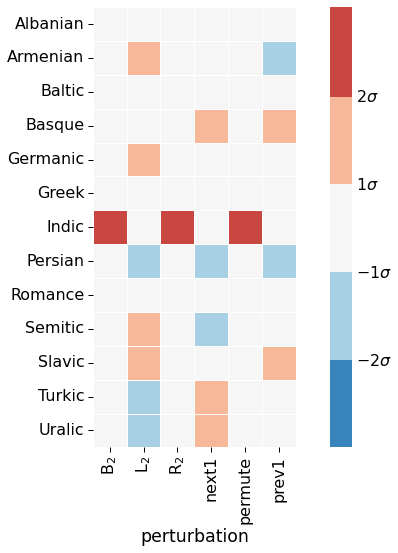

In [184]:
te = test_effect.reset_index()
te['family'] = te.language.apply(lambda l: lang2family[l])
te = te.groupby('family').mean()
te_std = te.std()
te_mean = te.mean()

te_discrete = pd.cut(((te - te_mean) / te_std).stack(), bins=[-1000, -2, -1, 1, 2, 1000], labels=[-2, -1, 0, 1, 2]).unstack().astype(int)
te_discrete
with sns.plotting_context('paper', font_scale=1.8):
    fig, ax = plt.subplots(1, figsize=(10, 8))
    sns.heatmap(te_discrete, ax=ax, cmap=sns.color_palette('RdBu_r', 5),
                linewidths=.5, vmin=-2, vmax=2, center=0, square=True)
    ax.set_ylabel("")
    colorbar = ax.collections[0].colorbar
    #colorbar.ax.set_frame_on(True)
    colorbar.ax.tick_params(size=0)
    ticklabels = [
        "$-2\sigma$",
        "$-1\sigma$",
        "$1\sigma$",
        "$2\sigma$",
    ]
    u = 2 / 2.5
    colorbar.set_ticks([-1.5*u, -0.5*u, 0.5*u, 1.5*u])
    colorbar.set_ticklabels(ticklabels)
    plt.tight_layout()
    fig.savefig(f"{figure_dir}/heatmap_family_effect_std_bin.pdf", bbox_inches='tight')

In [185]:
def do_cluster(K):
    #d = unfiltered['test_effect'][keep_perturbations]
    X = test_effect.pivot_table(index='language', columns='task')
    X = X.fillna(X.mean())
    k = KMeans(n_clusters=K)
    k.fit(X)
    clusters = [[] for _ in range(K)]
    for i, lab in enumerate(k.labels_):
        clusters[lab].append(X.index[i])
    print(f"K = {K}")
    print("\n------\n".join(", ".join(cl) for cl in clusters))
    
do_cluster(4)

/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


K = 4
Afrikaans, Albanian, Armenian, Basque, Bulgarian, Catalan, Danish, Dutch, English, French, Greek, Hebrew, Hindi, Hungarian, Italian, Latin, Latvian, Lithuanian, Norwegian_Bokmal, Norwegian_Nynorsk, Persian, Polish, Portuguese, Romanian, Russian, Slovak, Spanish, Swedish, Turkish, Ukrainian, Urdu
------
Croatian, Czech, German, Serbian, Slovenian
------
Estonian, Finnish
------
Arabic


In [196]:
test_effect.pivot_table(index='language', columns='task').columns

MultiIndex([('B$_2$',   'animacy_adj'),
            ('B$_2$',  'animacy_noun'),
            ('B$_2$', 'animacy_propn'),
            ('B$_2$',  'animacy_verb'),
            ('B$_2$',    'aspect_adj'),
            ('B$_2$',   'aspect_verb'),
            ('B$_2$',      'case_adj'),
            ('B$_2$',     'case_noun'),
            ('B$_2$',    'case_propn'),
            ('B$_2$',     'case_verb'),
            ...
            ('prev1',   'person_verb'),
            ('prev1',  'polarity_adj'),
            ('prev1', 'polarity_verb'),
            ('prev1',   'subcat_verb'),
            ('prev1', 'subgender_adj'),
            ('prev1',     'tense_adj'),
            ('prev1',    'tense_verb'),
            ('prev1', 'verbform_verb'),
            ('prev1',     'voice_adj'),
            ('prev1',    'voice_verb')],
           names=['perturbation', 'task'], length=246)